# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

### Целевой признак
* Price — цена (евро)

In [1]:
!pip install catboost

In [2]:
!pip install scikit-optimize

     |████████████████████████████████| 100 kB 1.7 MB/s ta 0:00:01


In [3]:
!pip install lightgbm

In [4]:
!pip install phik

     |████████████████████████████████| 679 kB 1.3 MB/s eta 0:00:01


In [5]:
import time
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, hstack

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer

from catboost import CatBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective

import lightgbm as lgb
from phik import phik_matrix


from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

## Подготовка данных

In [6]:
try: 
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('autos.csv')

### Знакомство с данными

Посмотрим на пропуски 

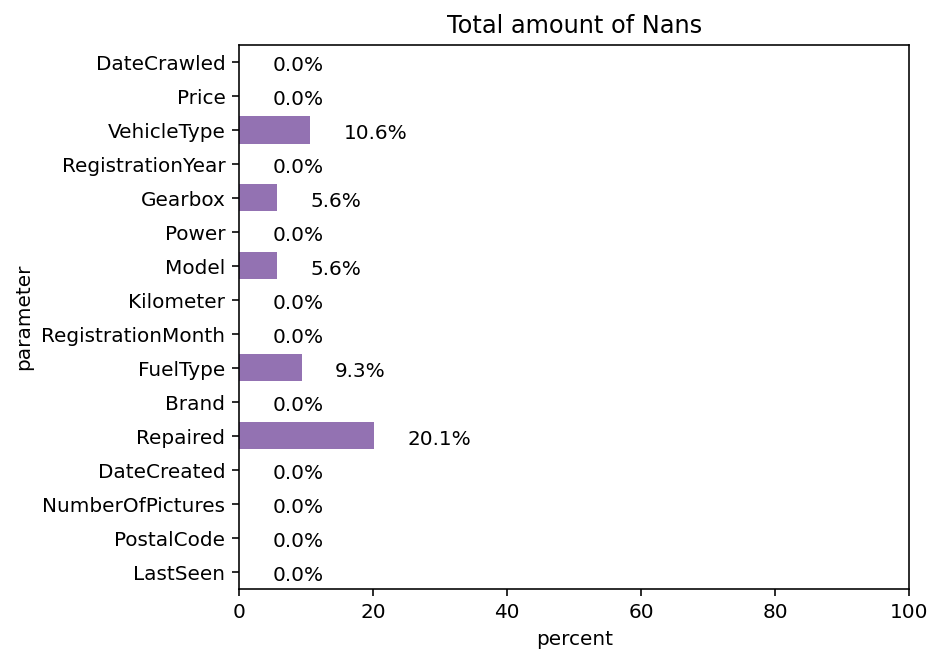

In [7]:
na_count = pd.DataFrame(data.isna().sum(axis=0)).rename(columns={0: "nans"}).reset_index()
na_count['percent'] = 100 * na_count['nans'] / data.shape[0]

fig, ax = plt.subplots(figsize=(6, 5))
for i in range(na_count.shape[0]):
    ax.annotate(f"{na_count.loc[i, 'percent']:.1f}%", xy=(na_count.loc[i, 'percent'] + 5, i+0.25) )
sns.barplot(data=na_count, y='index', x='percent', orient='h', ax=ax, color='tab:purple')
ax.set(xlim = (0, 100), ylabel="parameter", title="Total amount of Nans");

In [8]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Сделаем имена колонок по-другому

In [9]:
data.columns = data.columns.str.lower()
data = data.rename(
    columns={
        'datecrawled': 'date_crawled',
        'vehicletype': 'vehicle_type', 
        'registrationyear': 'registration_year',
        'registrationmonth': 'registration_month',
        'fueltype': 'fuel_type', 
        'datecreated' : 'date_created', 
        'numberofpictures' : 'number_pictures', 
        'postalcode' : 'postal_code',
        'lastseen': 'last_seen'
    }
)

Посмотрим на численные признаки

In [10]:
data.describe()

,price,registration_year,power,kilometer,registration_month,number_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Что видно сразу:

1. `number_pictures` - бесполезный, все значения нули
2. `price` и `power` - есть нулевые значения и, судя по `power`,  есть автомобили с ракетными двигателями)
3. `registration_year` - 1000, 9999 странное значение
4. `kilometer` - большинство значений сгруппировано около максимума 150_000, может так и должно быть, пока не ясно

In [11]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

### Обработка аномалий

#### Неинформативные признаки

Сразу удалю столбец с числом картинок - там везде одинаковое значение. И еще `registration_month` он мне сразу не понравился) но и чисто эмпирически он ничего не дал

In [12]:
data = data.drop(labels=['number_pictures', 'registration_month'], axis=1)

Отделим признаки по категориям, потом может пригодится

In [13]:
times = ['date_crawled', 'date_created', 'last_seen']
numbers = ['power', 'kilometer']
categorial = list(set(data.columns) - set(numbers) - set(times))

In [14]:
phik_mtx = phik_matrix(data.loc[:, numbers+categorial])

interval columns not set, guessing: ['power', 'kilometer', 'postal_code', 'price', 'registration_year']


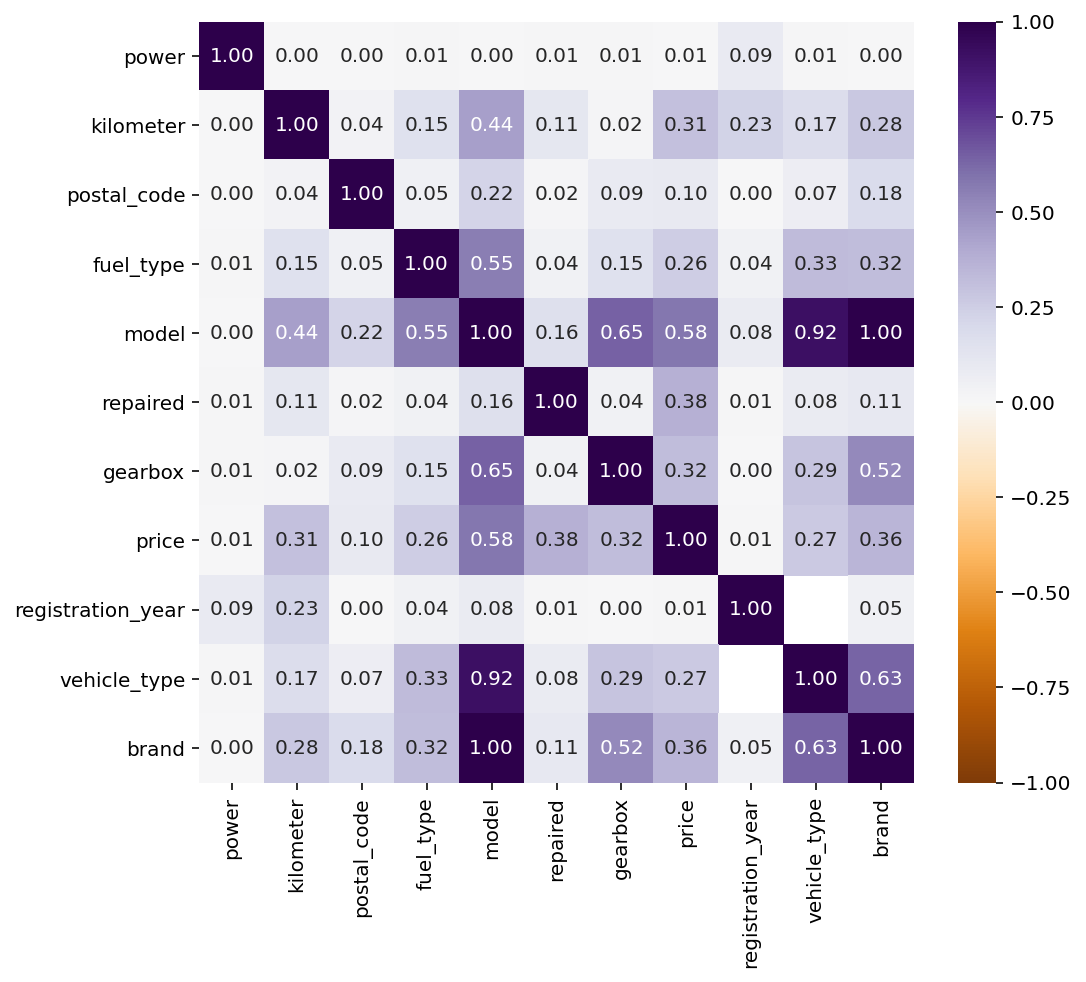

In [15]:
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(phik_mtx, 
            annot=True, 
            fmt='.2f',
            cmap=plt.cm.PuOr,
            vmin=-1, vmax=1
);

Получилась единица между `model` и `brand`. Как мне кажется, это логично по модели должно быть возможно восстановить бренд. Зависимость в `phik` матрице улавливается не обязательно линейная, поэтому можно оставить оба признака.

Удалим еще `price` из категориальных признаков

In [16]:
categorial.remove('price')

#### Нулевые значения


Ранее мы приметили, что в столбах `price` и `power` есть нулевые значения. `price` у нас целевая переменная, поэтому восстанавливать значения не будем, просто уберем нули

In [17]:
(data['price'] == 0).sum() / data.shape[0]

0.030397692800442477

3% не жалко)

In [18]:
data = data[data['price'] > 0].reset_index(drop=True)

Теперь оценим число нулей для `power`

In [19]:
(data['power'] == 0).sum() / data.shape[0]

0.1058216457070347

Тут уже жалко) Заполнять средним или медианой по всем значениям, мне кажется, не стоит, так как можно сделать похитрее. Например, есть предположение, что мощность машины будет связана с ее типом или брендом.

In [20]:
data.pivot_table(values='power', index='brand', columns='vehicle_type', aggfunc=['mean', 'median']).head()

mean                                                  \
vehicle_type         bus convertible       coupe       other       sedan   
brand                                                                      
alfa_romeo           NaN  137.711864  221.898230   86.714286  129.837719   
audi           89.900000  175.225806  184.919399  120.682243  143.353002   
bmw           112.833333  164.037199  158.037469  125.683036  158.265966   
chevrolet     166.365385  228.882353  180.550562  161.906977  120.134529   
chrysler      133.640964  145.697368  206.872340  140.666667  162.412186   

                                                 median                     \
vehicle_type       small         suv       wagon    bus convertible  coupe   
brand                                                                        
alfa_romeo    173.072340         NaN  152.454545    NaN       150.0  150.0   
audi           95.899220  208.774011  163.574582   75.0       163.0  180.0   
bmw           108.304348  184.995031  178.455236  150.0       170.0  150.0   
chevrolet      83.596552  168.482759  119.409524  163.0       193.0  190.0   
chrysler      129.250000  278.478261  162.485477  150.0       143.0  218.0   

                                                 
vehicle_type  other  sedan  small    suv  wagon  
brand                                            
alfa_romeo    104.5  135.5  105.0    NaN  150.0  
audi          115.0  131.0  101.0  239.0  150.0  
bmw           115.0  150.0  115.0  204.0  170.0  
chevrolet     163.0  124.0   68.0  163.0  121.0  
chrysler      140.0  143.0  140.5  180.0  141.0

Тут есть пропуски, но это может быть из-за того, что такой производитель просто не делает такой тип машин. Наверное, попроще будет брать медиану, дробя только по бренду - там изначально нет пропусков.

То есть идея следующая: сгруппировать мощности по бренду и брать медиану для каждого прощенного значения

In [21]:
brand_power_map = data.groupby(by='brand')['power'].agg(median_value="median")
brand_power_map.head()

,median_value
brand,
alfa_romeo,140
audi,143
bmw,150
chevrolet,113
chrysler,145


In [22]:
def set_power(x):
    return brand_power_map.loc[x['brand'], 'median_value']

In [23]:
missed = data['power'] == 0
data.loc[missed, 'power'] = data.loc[missed].apply(set_power, axis=1)

#### Странные значения


В столбце `power` были слишком большие значения

[(0.0, 400.0)]

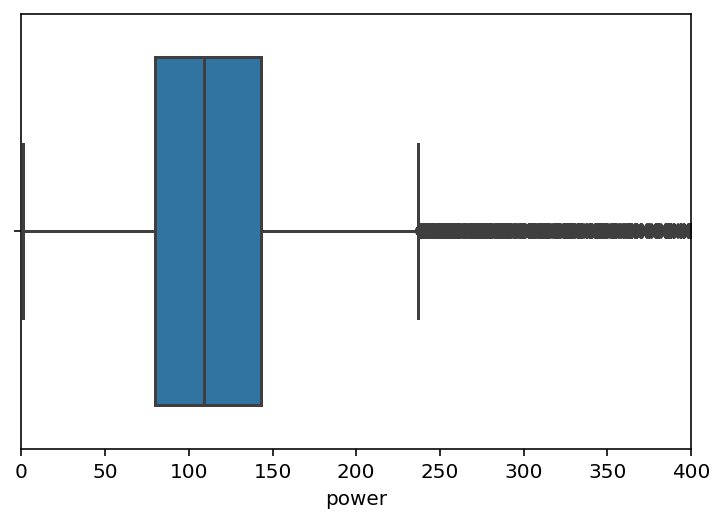

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.boxplot(data=data, x='power')
ax.set(xlim=(0, 400))

In [25]:
q1 = data['power'].quantile(0.25)
q3 =data['power'].quantile(0.75)

iqr = q3 - q1

In [26]:
data.query('power > (@q3 + 1.5 * @iqr)').shape[0] / data.shape[0]

0.02812306277412201

Думаю тремя процентами можно пожертвовать

In [27]:
data = data.query('power < (@q3 + 1.5 * @iqr)').reset_index(drop=True)

В столбце `registration_year` были замечены странные значения годов выпуска. Посмотрим на всевозможные года в наших данных

In [28]:
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1988, 1980, 1970,
       1986, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 5000, 1958, 1967, 1956, 3200,
       1000, 1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940,
       3000, 2066, 1949, 2019, 1937, 1951, 1959, 1953, 1954, 1234, 8000,
       5300, 9000, 2900, 6000, 5900, 5911, 1950, 1948, 1952, 8500, 1932,
       1255, 3700, 3800, 4800, 1942, 7000, 4000, 1935, 1933, 1936, 6500,
       1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1934, 1938, 1928,
       1800, 5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931, 4500,
       1602, 7800, 1947, 1927, 7100, 8200, 1946])

Тээк... Сначала посчитаем число опечаток

In [29]:
looks_fine = (data['registration_year'] < 2023) & (data['registration_year'] > 1900)
data.loc[~looks_fine].shape

(124, 14)

Их немного, это очень радует. Тогда я сделаю так: в значениях, где опечатки очевидные, типо 9999 вместо 1999, я поменяю значения сам, остальное выбросим.

In [30]:
def fix_typos(year):
    if year % 1000 == 0:
        year = 2000
    elif str(year)[0] != '1' and str(year)[1] == '9':
        year = 1000 + year % 1000
    return year
    

In [31]:
data.loc[~looks_fine, 'registration_year'] = data.loc[~looks_fine, 'registration_year'].apply(fix_typos)

In [32]:
looks_fine = (data['registration_year'] < 2023) & (data['registration_year'] > 1900)
data.loc[~looks_fine].shape

(45, 14)

Ну больше половины, я надеюсь, мы спасли, остальные выкидываем

In [33]:
data = data.loc[looks_fine]
(data['power'] == 0).sum()

0

In [34]:
data['date_created'] = pd.to_datetime(data['date_created'], format='%Y-%m-%d %H:%M:%S')

In [35]:
indexes_wrong_year = (data['date_created'].dt.year < data['registration_year'])
data.loc[indexes_wrong_year, 'registration_year'] = data.loc[indexes_wrong_year, 'date_created'].dt.year

Еще я посчитал странным, что куча значений пробега находится на 150_000 км. Посмотрим поближе

Text(0, 0.5, 'Количество')

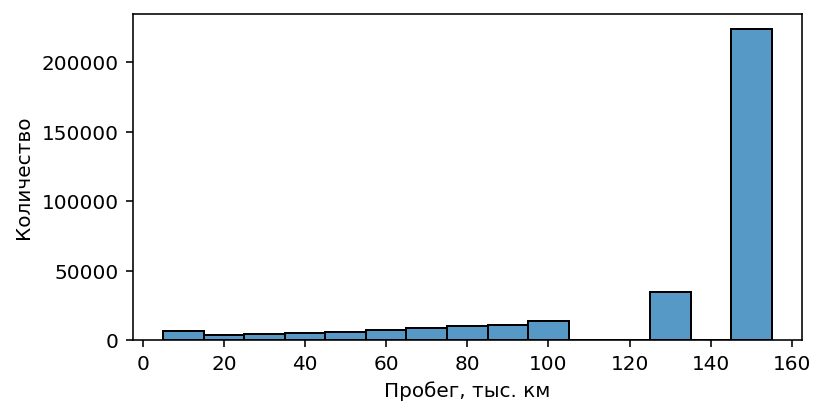

In [36]:
plt.figure(figsize=(6, 3))
sns.histplot(data['kilometer']/1000, binwidth=10)
plt.xlabel('Пробег, тыс. км')
plt.ylabel('Количество')

Вообще эти значения слишком "красивые" и скорее похожи на попадание в категорию. То есть до 50 тыс. км, до 80 тыс. км и последняя более 150 тыс. км.. Не понятно, что делать с этим признаком и нужно ли вообще что-то делать, скорее всего нужно относится к нему как к категориальному

In [37]:
numbers.remove('kilometer')
categorial.append('kilometer')

#### Пропуски

На данный момент у нас есть пропуски в следующих категориях

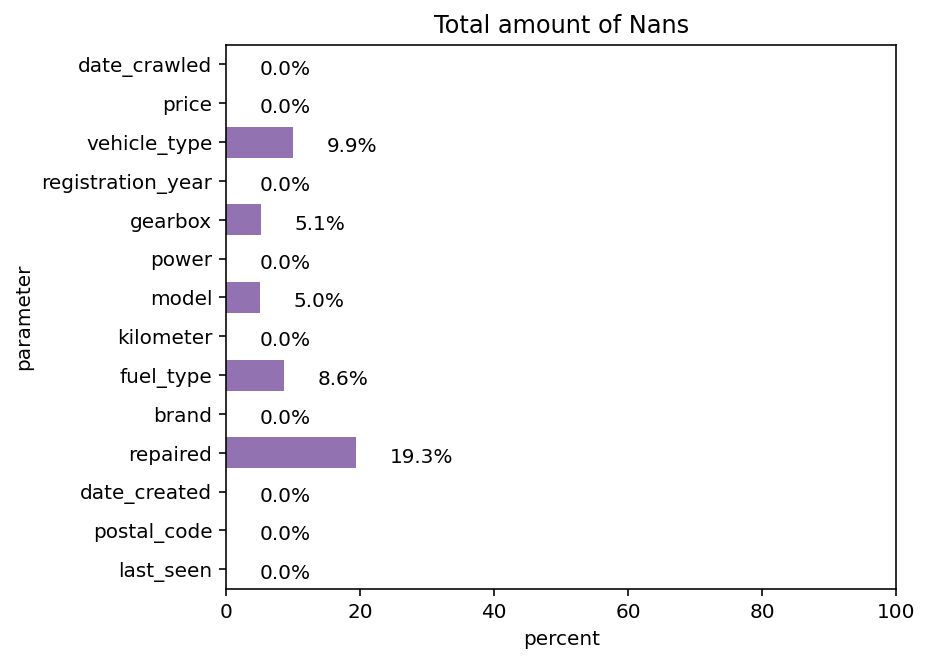

In [38]:
na_count = pd.DataFrame(data.isna().sum(axis=0)).rename(columns={0: "nans"}).reset_index()
na_count['percent'] = 100 * na_count['nans'] / data.shape[0]

fig, ax = plt.subplots(figsize=(6, 5))
for i in range(na_count.shape[0]):
    ax.annotate(f"{na_count.loc[i, 'percent']:.1f}%", xy=(na_count.loc[i, 'percent'] + 5, i+0.25) )
sns.barplot(data=na_count, y='index', x='percent', orient='h', ax=ax, color='tab:purple')
ax.set(xlim = (0, 100), ylabel="parameter", title="Total amount of Nans");

##### Repaired
Пропусков 20%, признак бинарный, есть средняя корреляция с ценой, но цена это целевая переменная - так нечестно восстанавливать пропуски. 

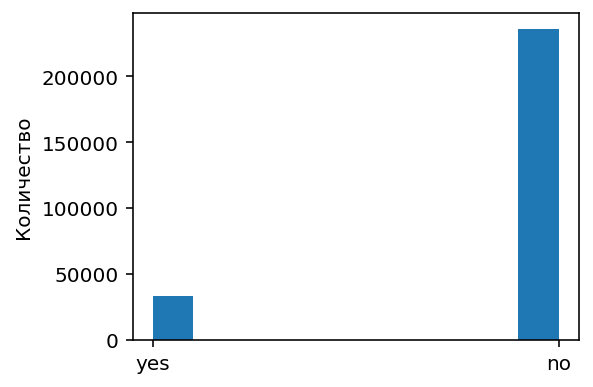

In [39]:
plt.figure(figsize=(4, 3))
plt.hist(data.loc[~data['repaired'].isna(), 'repaired'].values)
plt.ylabel('Количество');


Попробуем в качестве эксперимента сделать `nan` отдельной категорией

In [40]:
unknown = data['repaired'].isna()
data.loc[unknown, 'repaired'] = 'unknown'

##### Vehicle type 
Ситуация такая же как и в предыдущем типе. Значений пропущено приличное количество, поэтому выкидывать не хочется. Так же сделаем новую категорию

In [41]:
missed = data['vehicle_type'].isna()
data.loc[missed, 'vehicle_type'] = 'unknown'

##### Model


Наибольшая корреляция у этого признака была с `brand`, значит будем заполнять модой, сгруппировав по бренду

In [42]:
missed = data['model'].isna()

In [43]:
brand_model_map = data.groupby(by='brand')['model'].agg(
    value=lambda x: pd.Series.mode(x) if len(pd.Series.mode(x)) > 0 else np.nan  # Подстраховка если для всей группы значения пропущено
)

In [44]:
data.loc[missed, 'model'] = data.loc[missed].apply(
    lambda x: brand_model_map.loc[x['brand'], 'value'],
    axis=1
)

In [45]:
data['model'].isna().sum() / data.shape[0]

0.007409648116589645

In [46]:
data.loc[data['model'].isna(), 'brand'].unique()

array(['sonstige_autos'], dtype=object)

То есть пропущенные значения все у одного бренда и их меньше 1% и категория, если перевести, называется "другие авто" - удалю пожалуй)

In [47]:
missed = data['model'].isna()
data = data[~missed]

##### Gear box

In [48]:
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [49]:
missed = data['gearbox'].isna()

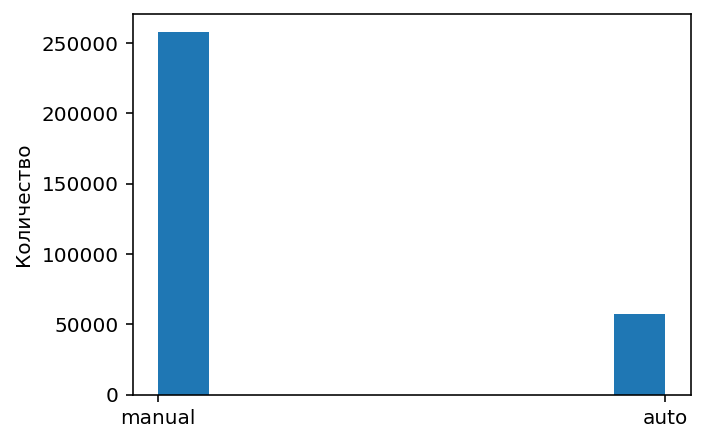

In [50]:
plt.figure(figsize=(5, 3.5))
plt.hist(data.loc[~missed, 'gearbox'].values)
plt.ylabel('Количество');

Тут ситуация в целом напоминает `repaired` только все-таки число пропусков в 4 раза меньше,  поэтому заполним пропуски как `manual`

In [51]:
data.loc[missed, 'gearbox'] = 'manual'

##### Fuel type


In [52]:
data['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [53]:
model_fuel_map = data.groupby('model')['fuel_type'].agg(value=pd.Series.mode)

In [54]:
missed = data['fuel_type'].isna()
data.loc[missed, 'fuel_type'] = data.loc[missed].apply(
    lambda x: model_fuel_map.loc[x['model'], 'value'],
    axis=1
)

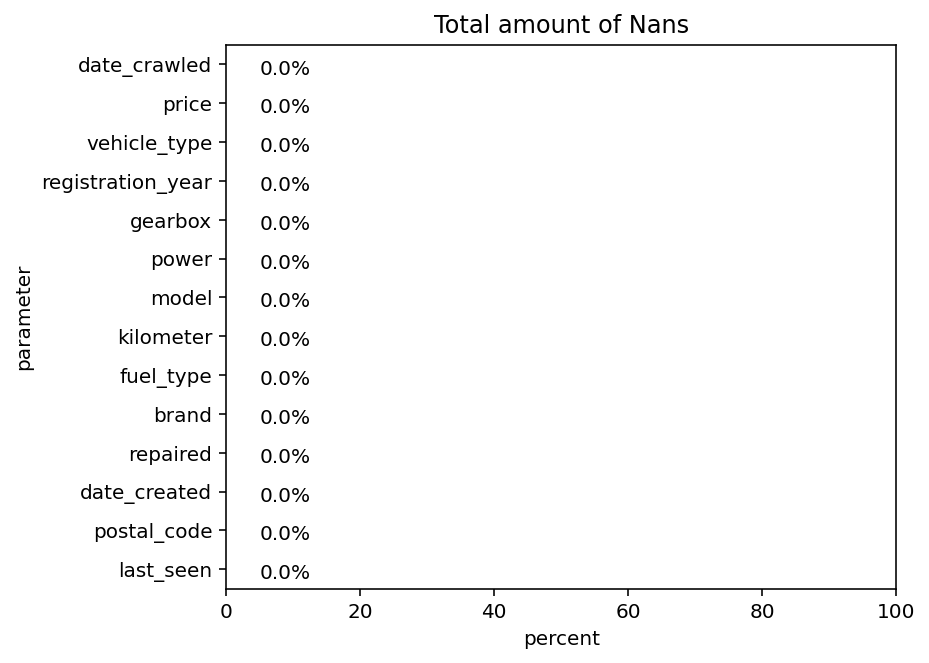

In [55]:
na_count = pd.DataFrame(data.isna().sum(axis=0)).rename(columns={0: "nans"}).reset_index()
na_count['percent'] = 100 * na_count['nans'] / data.shape[0]

fig, ax = plt.subplots(figsize=(6, 5))
for i in range(na_count.shape[0]):
    ax.annotate(f"{na_count.loc[i, 'percent']:.1f}%", xy=(na_count.loc[i, 'percent'] + 5, i+0.25) )
sns.barplot(data=na_count, y='index', x='percent', orient='h', ax=ax, color='tab:purple')
ax.set(xlim = (0, 100), ylabel="parameter", title="Total amount of Nans");

Итак, с пропусками и странными значениями разобрались наконец

### Временные признаки

In [56]:
data[times].head()

,date_crawled,date_created,last_seen
0,2016-03-24 11:52:17,2016-03-24,2016-04-07 03:16:57
1,2016-03-24 10:58:45,2016-03-24,2016-04-07 01:46:50
2,2016-03-14 12:52:21,2016-03-14,2016-04-05 12:47:46
3,2016-03-17 16:54:04,2016-03-17,2016-03-17 17:40:17
4,2016-03-31 17:25:20,2016-03-31,2016-04-06 10:17:21


`date_created` в целом повторяет столбец `date_crawled`, только без точного времени, поэтому на него особо внимания не будем обращать. Последний столбец - время последней активности пользователя. Мне на ум приходит только создать новый признак как разницу между датой скачивания и последним заходом  

In [57]:
data[times] = data.loc[:, times].apply(pd.to_datetime, format="%Y-%m-%d %H:%M:%S")

In [58]:
data['minutes'] = (data['last_seen']- data['date_crawled']).dt.total_seconds() // 60

In [59]:
data = data.drop(labels=times, axis=1)

In [60]:
numbers.append('minutes')

### Дубликаты 

In [61]:
data.duplicated().sum()

2266

In [62]:
data.drop_duplicates(inplace=True)

## Обучение моделей

В этом разделе попробуем сравнить четыре модели машинного обучения

1. Ridge model
2. RandomForest
3. CatBoost
4. LightGBM

Сравнивать их мы будем по RMSE и относительному времени обучения __лучшей__ модели. То есть я не буду сравнивать время, потраченное на поиск лучших гиперпараметров. Также будем смотреть на время предсказания

In [63]:
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))

Разделим выборку на тренировочную и тестовую

In [64]:
features = data.drop('price', axis=1)
target = data['price']

In [65]:
features[categorial] = features[categorial].apply(LabelEncoder().fit_transform)

In [66]:
seed = 4 
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.3, 
                                                                            random_state=seed
                                                                           )

Идея функции в том, чтобы принимать модель для оптимизации гиперпараметров и сам вид оптимизации `GridSeacrhCV`, `RandomizedSearchCV` или `BayesSearchCV`. 

In [67]:
def search_best_model(model, reseacher, x, y, params, n_iter):
    '''
        model - модель для обучения
        reseacher - метод поиска гиперпараметров
        x - признаки
        y - целевая переменная 
        params - параметры поиска для reseacher
    '''
    grid = reseacher(model, params,
        n_jobs=-1, 
        cv=5, 
        n_iter=n_iter,
        scoring=make_scorer(rmse, greater_is_better=False)
    )
    grid.fit(x, y)
    return grid
    

Еще определим функцию, которая будет брать лучшую модель и выдавать время и результат RMSE на обучающей выборке

In [68]:
def model_review(model, x_train, y_train):
    t1 = time.time()
    model.fit(x_train, y_train)
    train_time = time.time() - t1
    
    train_score = rmse(y_train, model.predict(x_train))
    return train_time, train_score

Создадим таблицу с результатами для дальнейшего анализа

In [69]:
models_review = pd.DataFrame(index=['time', 'rmse'])

### Ridge

#### LabelEncoder

###### Подбор параметров

In [70]:
pipe = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('lin_model', Ridge(random_state=seed))
    ]
)

In [71]:
ridge_le_params = {
        'lin_model__alpha': Real(1e-04, 100, prior='uniform'), 
}

Учится порядка 3 минут

In [72]:
ridge_le = search_best_model(pipe, BayesSearchCV, features_train, target_train, ridge_le_params, n_iter=50)

Можно еще посмотреть насколько хорошо определились гиперпараметры

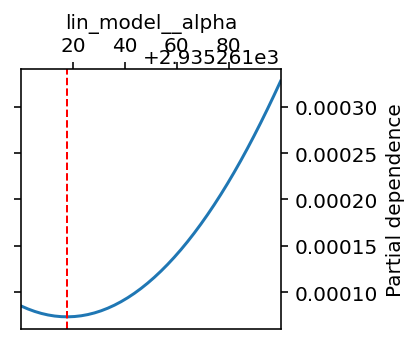

In [73]:
plot_objective(ridge_le.optimizer_results_[0], levels=100);

In [74]:
ridge_le.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('lin_model', Ridge(alpha=17.52531482631429, random_state=4))])

###### Оценка времен

In [75]:
pipe = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('lin_model', Ridge(alpha=17.64, random_state=seed))
    ]
)

In [76]:
models_review['rigle_le'] = model_review(pipe, features_train, target_train)

In [77]:
models_review

,rigle_le
time,0.065219
rmse,2935.105116


#### OneHotEncoder

Два способа

1. Полный - все категориальные признаки делаем через `ohe`. RMSE будет около 2000. НО... может сработать не у каждого, так как даже через разреженные матрицы это процедура съела у меня 11 Гб памяти. Поэтому здесь я его не привожу

2. Частичный - сделать `ohe` преобразование только для относительно не больших признаков. Тогда и разреженные матрицы не нужны

##### Частичный OHE

###### Подбор параметров

Выделяется признаки, в которых меньше 15 категорий, чтобы можно было посчитать и не переполнить память

In [78]:
small_cat = features[categorial].apply(lambda x: len(np.unique(x)) <= 15, axis=0).\
                                 reset_index()

small_cat.columns = ['cat_features', 'label']

cat_to_ohe = small_cat.loc[small_cat['label'], 'cat_features'].values
cat_stay_le = small_cat.loc[~small_cat['label'], 'cat_features'].values

In [80]:
part_ohe_transform = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numbers + list(cat_stay_le)),
        ('part_ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_to_ohe)
    ]
)

In [81]:
pipe_ohe = Pipeline(

    steps=[
        ('ohe', part_ohe_transform),
        ('lin_model', Ridge(random_state=seed))
    ]
)

Тут параметры поиска такие же, только признаки изменены

Учится порядка 10-15 минут

In [82]:
ridge_ohe_params = {
        'lin_model__alpha': Real(0, 150, prior='uniform'), 
}

In [83]:
ridge_part_ohe = search_best_model(pipe_ohe, BayesSearchCV, features_train, target_train, ridge_ohe_params, 50)

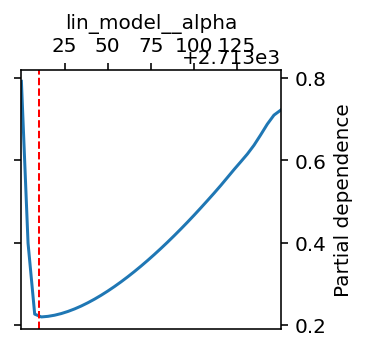

In [84]:
plot_objective(ridge_part_ohe.optimizer_results_[0], levels=10);

In [85]:
ridge_part_ohe.best_estimator_


Pipeline(steps=[('ohe',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['power', 'minutes',
                                                   'postal_code', 'model',
                                                   'registration_year',
                                                   'brand']),
                                                 ('part_ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  array(['fuel_type', 'repaired', 'gearbox', 'vehicle_type', 'kilometer'],
      dtype=object))])),
                ('lin_model', Ridge(alpha=9.989554050785824, random_state=4))])

###### Оценка времен

In [86]:
pipe_ohe = Pipeline(

    steps=[
        ('ohe', part_ohe_transform),
        ('scaler', StandardScaler()),
        ('lin_model', Ridge(alpha=9.97, random_state=seed))
    ]
)

In [87]:
models_review['rigle_part_ohe'] = model_review(pipe_ohe, features_train, target_train)

In [88]:
models_review

,rigle_le,rigle_part_ohe
time,0.065219,0.600760
rmse,2935.105116,2712.577175


### RandomForest

Теперь попробуем ансамбли. Здесь, мне кажется, `LabelEnconding` будет достаточно. Этот алгоритм не должен зависеть от такого разбиения признаков

#### LabelEncoder

###### Подбор параметров

In [90]:
rf_le_model = RandomForestRegressor(random_state=seed, warm_start=True)

In [91]:
rf_le_params = {
    'n_estimators': Integer(1, 50), 
    'max_depth': Integer(2, 10)
}

Счиается около 30 минут

In [ ]:
t1 = time.time()
rf_le_grid = search_best_model(rf_le_model, BayesSearchCV, features_train, target_train, rf_le_params, 20)
t2 = (time.time() - t1) / 60
print(f"Время подбора {t2:1f} минут")

In [ ]:
rf_le_grid.best_estimator_

In [ ]:
plot_objective(rf_le_grid.optimizer_results_[0], levels=10);

###### Оценка времен

In [ ]:
rf_le_model = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=seed, warm_start=True)

In [ ]:
models_review['rf_le_model'] = model_review(rf_le_model, features_train, target_train)

In [ ]:
models_review

В данном случае лучшая модель получилась из 50 деревьев с глубиной 10. Можно получить и получше, приблизительно 1548 выйдет для модели из 150 деревьев с глубиной в 24, но обучаться такая модель будет существенно дольше. 

В принципе и здесь видно, что RF сработал лучше линейной модели.

#### OrdinalEncoder

In [ ]:
part_oe_transform = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numbers),
        ('part_ohe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorial)
    ]
)

In [ ]:
pipe_oe = Pipeline(

    steps=[
        ('oe', part_oe_transform),
        ('rf_model', RandomForestRegressor(warm_start=True, random_state=seed))
    ]
)

###### Подбор параметров

In [ ]:
rf_oe_params = {
    'rf_model__n_estimators': Integer(1, 50), 
    'rf_model__max_depth': Integer(2, 10)
}

Счиается около 30 минут

In [ ]:
t1 = time.time()
rf_oe_grid = search_best_model(pipe_oe, BayesSearchCV, features_train, target_train, rf_oe_params, 20)
t2 = (time.time() - t1) / 60
print(f"Время подбора {t2:1f} минут")

In [ ]:
rf_oe_grid.best_estimator_

In [ ]:
plot_objective(rf_oe_grid.optimizer_results_[0], levels=10);

###### Оценка времен

In [ ]:
pipe_oe = Pipeline(
    steps=[
        ('oe', part_oe_transform),
        ('rf_model', RandomForestRegressor(max_depth=10, n_estimators=50, warm_start=True, random_state=seed))
    ]
)

In [ ]:
models_review['rf_oe_model'] = model_review(pipe_oe, features_train, target_train)

In [ ]:
models_review

### LightGBM

Здесь начинаем исследовать алгоритмы градиентного бустинга. У них большое число параметров для варирования, но для `LightGBM` я выделил три основных, на мой взгляд, и варьировал их.

In [ ]:
categorial_num = [list(categorial).index(i) for i in categorial]

In [ ]:
lgbm_model = lgb.LGBMRegressor(
    random_state=seed, 
    categorical_feature=categorial_num,
    metric='rmse'
)

In [ ]:
lgbm_model.fit(features_train, target_train, categorical_feature=categorial_num,)

In [ ]:
rmse(target_train, lgbm_model.predict(features_train))

###### Подбор параметров

In [ ]:
lgbm_model = lgb.LGBMRegressor(
    random_state=seed, 
    categorical_feature=categorial_num,
    metric='rmse'
)

In [ ]:
lgbm_params = {
#     'max_depth': [8, 10, 12, 14],
    'max_depth': [12],
    'learning_rate': [0.1, 0.2, 0.3]
}

In [ ]:
lgbm_grid = GridSearchCV(
    estimator=lgbm_model,
    param_grid=lgbm_params,
    cv=5,
    n_jobs=-1,
    scoring=make_scorer(rmse, greater_is_better=False),
    
)

На платформе считается очень долго, даже если варьировать только один параметр :(

In [ ]:
t1 = time.time()
lgbm_grid.fit(features_train, target_train)
t2 = (time.time() - t1) / 60
print(f"Время подбора {t2:1f} минут")

In [ ]:
lgbm_grid.best_estimator_

###### Оценка времен

In [ ]:
lgbm_model = lgb.LGBMRegressor(
    categorical_feature=categorial_num,
    learning_rate=0.2, 
    max_depth=12,
    metric='rmse', 
    random_state=seed
)

In [ ]:
models_review['lgbm_model'] = model_review(lgbm_model, features_train, target_train)

In [ ]:
models_review

По общему показателю `LighGBM` обошел `RF`

### Catboost


Последний из алгоритмов, которые я хотел бы попробовать в данной работе. Насколько я понял из документации ему можно отдать датасет без настроек, указав категориальные признаки и он самостоятельно их закодирует

Попробуем запустить, ничего не настраивая

In [ ]:
ya_model = CatBoostRegressor(
    random_seed=seed, 
    loss_function='RMSE',
    cat_features=categorial, 
    task_type='CPU', 
    verbose=0
)

In [ ]:
%%time
ya_model.fit(features_train, target_train)

In [ ]:
rmse(target_train, ya_model.predict(features_train))

Я растроен.. Я так долго выбивал прошлый результат, а тут из коробки вышло даже лучше

###### Подбор параметров

В [документации](https://catboost.ai/en/docs/concepts/speed-up-training) говорят, что `learning_rate` подстраивается сам. Попробуем поменять глубину деревьев

In [ ]:
ya_model = CatBoostRegressor(
    random_seed=seed, 
    loss_function='RMSE',
    cat_features=categorial, 
    task_type='CPU', 
    verbose=0
)

In [ ]:
ya_params = {'max_depth': range(9, 13)}

Считается около двух часов

In [ ]:
ya_grid = ya_model.grid_search(ya_params, X=features_train, y=target_train, )

###### Оценка времен

In [ ]:
ya_model = CatBoostRegressor(
    depth=12,
    random_seed=seed, 
    loss_function='RMSE',
    cat_features=categorial, 
    task_type='CPU', 
    verbose=0
)

In [ ]:
models_review['ya_model'] = model_review(ya_model, features_train, target_train)

In [ ]:
models_review

## Анализ моделей

In [ ]:
models_review = models_review.T

In [ ]:
models_review['ratio_time'] = models_review['time'] / models_review['time'].min()

In [ ]:
models_review.reset_index()

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3.5))

sns.lineplot(data=models_review.reset_index(), ls='--', ms=8, marker='D', x='index', y='rmse')
ax.hlines(2500, -0.2, 5.2, colors='k', ls=':')
ax.annotate('Threshold', (2.2, 2550))
ax.legend(['Train'])
ax.set_xticklabels(models_review.index, rotation=30)
ax.set(
    xlim=(-0.2, 5.2),
    ylabel='RMSE',
    xlabel='Model',
    title='RMSE Score'
);


Порог в 2500 удалось преодолеть четырем моделям из шести. Лучше всего справился алгоритм `CatBoost` со значением 1470

In [ ]:
models_review[['time', 'ratio_time']]

Однако хорошо видно, что цена лучшего значения метрике обошлась в очень долгие вычисления. Алгоритм `CatBoost` оказался намного медленнее, чем `LightGBM`, который проиграл по RMSE около 70

In [ ]:
print(f"Constant model score: {rmse(target_test, target_test.mean() * np.ones(target_test.shape))}")

In [ ]:
print(f"Test score: {rmse(target_test, ya_model.predict(features_test)):.2f}")

Обученная модель также дает существенно лучшие результаты по сравнению с константной моделью

## Вывод

Целью данного проекта было определение наиболее подходящей модели машинного обучения для сервиса по продаже автомобилей "Не бит, не крашен". Выбор модели осуществлялся, опираясь на три показателя: качество предсказания (оценивалось по метрике RMSE), время обучения и время предсказания. 

Всего в работе были рассмотрены четыре вида моделей. Для модели линейной регрессии было предложено два варианта представления признаков для обучения. Данные предоставленные для обучения модели были предварительно проанализированы и очищены от паразитных значений для более качественного обучения моделей. 

В итоге к внедрению в структуру сервиса рекомендуется модель `LighGBM`. Данная модель показала наилучший показатель в совокупности по всем трем компонентам. Однако, несколько уступила модели `CatBoost` по качеству предсказания. Несмотря на этот факт, рекомендуется именно эта модель в силу более быстрого обучения, что также важно для работы сервера. Если же имеется возможность заранее предобучить модель, то имеет смысл воспользоваться алгоритмом библиотеки `CatBoost`. Несмотря на то, что относительное время предсказания этой модели хуже в разы, чем у `LighGBM`, но в реальных величинах речь идет о долях секунды, что не значительно.